<a href="https://colab.research.google.com/github/gizemdoglu/Plant-Diseases-Detection/blob/master/tomato_leaf_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
import numpy as np
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**Parameters**

In [0]:
EPOCHS = 25 # Eğitim "25" epoch sürsün
INIT_LR = 1e-3
BS = 32 # Her bir iterasyonda "32" resim alınsın
default_image_size = tuple((256, 256)) # Giriş resimlerinin boyutları 256 x 256 piksel
image_size = 0
directory_root = '/content/drive/My Drive/Images of Leaf Diseases/tomato/train'
width=256
height=256
depth=3

**Function to Convert Images to Array**

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

**Fetch Images From Directory**

In [0]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # Remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    plant_disease_folder_list = listdir(f"{directory_root}")

    for disease_folder in plant_disease_folder_list :
      # Remove .DS_Store from list
      if disease_folder == ".DS_Store" :
        plant_disease_folder_list.remove(disease_folder)
    
    for plant_disease_folder in plant_disease_folder_list:
      print(f"[INFO] Processing {plant_disease_folder} ...")
      plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/")
                
      for single_plant_disease_image in plant_disease_image_list :
        if single_plant_disease_image == ".DS_Store" :
          plant_disease_image_list.remove(single_plant_disease_image)
      
      for image in plant_disease_image_list[:200]:
        image_directory = f"{directory_root}/{plant_disease_folder}/{image}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
          image_list.append(convert_image_to_array(image_directory))
          label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  

except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Bacterial_Spot ...
[INFO] Processing Early_Blight ...
[INFO] Processing Late_Blight ...
[INFO] Processing Leaf_Mold ...
[INFO] Processing Septoria_Leaf_Spot ...
[INFO] Processing Target_Spot ...
[INFO] Processing Yellow_Leaf_Curl_Virus ...
[INFO] Processing Mosaic_Virus ...
[INFO] Processing Healthy ...
[INFO] Processing Two-Spotted_Spider_Mite ...
[INFO] Image loading completed


**Get Size of Processed Image**

In [0]:
image_size = len(image_list)

**Transform Image Labels using Scikit Learn's LabelBinarizer**

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

np_image_list = np.array(image_list, dtype=np.float16) / 225.0

['Bacterial_Spot' 'Early_Blight' 'Healthy' 'Late_Blight' 'Leaf_Mold'
 'Mosaic_Virus' 'Septoria_Leaf_Spot' 'Target_Spot'
 'Two-Spotted_Spider_Mite' 'Yellow_Leaf_Curl_Virus']


**Splitting Data**

In [0]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

[INFO] Spliting data to train, test


**Model Build**

In [0]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
    
print('x_train Shape:', x_train.shape)
print('x_test Shape:', x_test.shape)
print('\nTrain Samples:', x_train.shape[0])
print('Test Samples:', x_test.shape[0])

# 3x3 boyutunda 32 adet filtreden oluşan ReLU aktivasyonlu CONV katmanı ekleyelim
model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=inputShape))
model.add(BatchNormalization(axis=chanDim))

# 3x3 boyutlu çerçeveden oluşan MAXPOOL katmanı ekleyelim
model.add(MaxPooling2D(pool_size=(3, 3)))

# Her seferinde nöronların %25'i atılsın (drop)
model.add(Dropout(0.25))

# 3x3 boyutunda 64 adet filtreden oluşan ReLU aktivasyonlu CONV katmanı ekleyelim
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization(axis=chanDim))

# 3x3 boyutunda 64 adet filtreden oluşan ReLU aktivasyonlu CONV katmanı ekleyelim
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization(axis=chanDim))

# 2x2 boyutlu çerçeveden oluşan MAXPOOL katmanı ekleyelim
model.add(MaxPooling2D(pool_size=(2, 2)))

# Her seferinde nöronların %25'i atılsın (drop)
model.add(Dropout(0.25))

# 3x3 boyutunda 128 adet filtreden oluşan ReLU aktivasyonlu CONV katmanı ekleyelim
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization(axis=chanDim))

# 3x3 boyutunda 128 adet filtreden oluşan ReLU aktivasyonlu CONV katmanı ekleyelim
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization(axis=chanDim))

# 2x2 boyutlu çerçeveden oluşan MAXPOOL katmanı ekleyelim
model.add(MaxPooling2D(pool_size=(2, 2)))

# Her seferinde nöronların %25'i atılsın (drop)
model.add(Dropout(0.25))

# Tam bağlantılı (fully connected) katmanına geçiş olacağı için düzleştirme yapalım
model.add(Flatten())

# 1024 nörondan oluşan ReLU aktivasyonlu FC katmanı ekleyelim
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())

# Her seferinde nöronların %25'i atılsın (drop)
model.add(Dropout(0.5))

# Çıkış katmanına sınıf sayısı kadar Softmax aktivasyonlu nöron ekleyelim
model.add(Dense(n_classes, activation='softmax'))

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# Distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# Train the Network
print("\n[INFO] training network...")

x_train Shape: (1600, 256, 256, 3)
x_test Shape: (400, 256, 256, 3)

Train Samples: 1600
Test Samples: 400

[INFO] training network...


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 85, 85, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 85, 64)       

**Performing Training**

In [0]:
# Eğitim işlemini gerçekleştirelim

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
50/50 [==============================] - 22s 446ms/step - loss: 0.2763 - accuracy: 0.9101 - val_loss: 1.0746 - val_accuracy: 0.8183
Epoch 2/25
50/50 [==============================] - 21s 412ms/step - loss: 0.2158 - accuracy: 0.9231 - val_loss: 1.3698 - val_accuracy: 0.8180
Epoch 3/25
50/50 [==============================] - 21s 413ms/step - loss: 0.2273 - accuracy: 0.9234 - val_loss: 1.4145 - val_accuracy: 0.8218
Epoch 4/25
50/50 [==============================] - 21s 417ms/step - loss: 0.1874 - accuracy: 0.9355 - val_loss: 1.5783 - val_accuracy: 0.8180
Epoch 5/25
50/50 [==============================] - 21s 420ms/step - loss: 0.1513 - accuracy: 0.9491 - val_loss: 0.8820 - val_accuracy: 0.8435
Epoch 6/25
50/50 [==============================] - 21s 425ms/step - loss: 0.1489 - accuracy: 0.9464 - val_loss: 1.5144 - val_accuracy: 0.8257
Epoch 7/25
50/50 [==============================] - 22s 437ms/step - loss: 0.1287 - accuracy: 0.9541 - val_loss: 0.9456 - val_accuracy: 0.8503

**Performing Testing and Showing the Results**

In [0]:
# Test işlemini gerçekleştirelim ve sonuçları ekrana yazdıralım

score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0]*100)
print('Test Accuracy:', score[1]*100)

Test Loss: 9.803174078464508
Test Accuracy: 96.39999866485596


**Graphs**

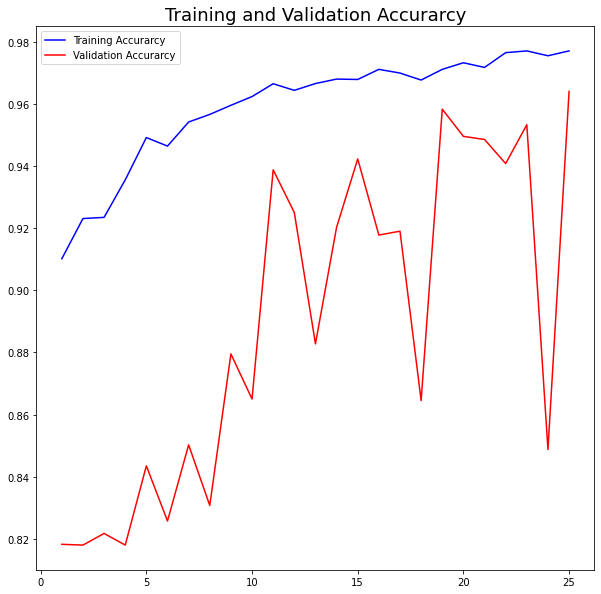

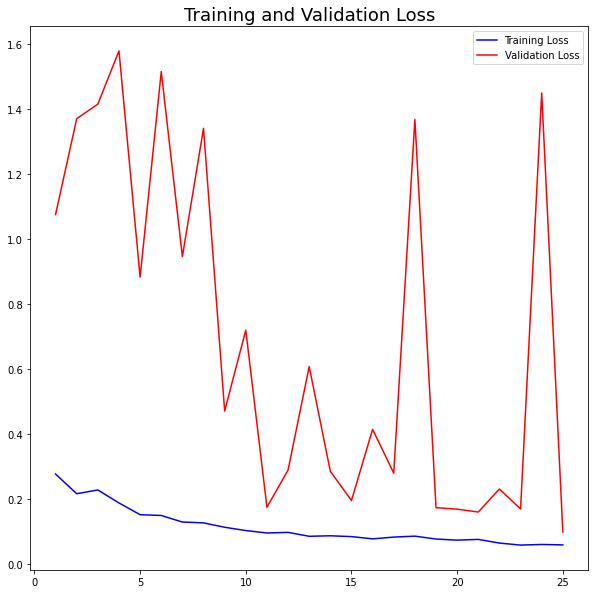

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and Validation Accuracy
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(epochs, acc, 'b', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy', fontsize=18)
plt.legend()

plt.figure()
# Train and Validation Loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=18)
plt.legend()
plt.show()

**Making Predictions**

In [0]:
y_pred = model.predict(x_test)

# Getting Labels
y_pred_labels = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_test,axis = 1)

**Making Confusion Matrix**

In [0]:
# Creating a Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true,y_pred_labels)

**Visualizing Confusion Matrix**

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


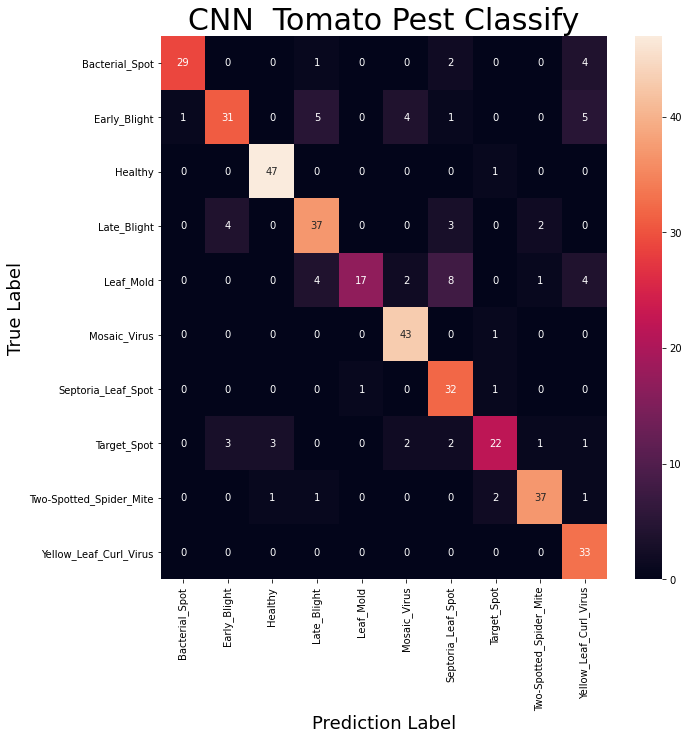

In [0]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = ['Bacterial_Spot', 'Early_Blight', 'Healthy', 'Late_Blight', 'Leaf_Mold',
 'Mosaic_Virus', 'Septoria_Leaf_Spot', 'Target_Spot', 'Two-Spotted_Spider_Mite', 'Yellow_Leaf_Curl_Virus'],

                     columns = ['Bacterial_Spot', 'Early_Blight', 'Healthy', 'Late_Blight', 'Leaf_Mold',
 'Mosaic_Virus', 'Septoria_Leaf_Spot', 'Target_Spot', 'Two-Spotted_Spider_Mite', 'Yellow_Leaf_Curl_Virus'])

plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot = True)
plt.title('CNN  Tomato Pest Classify', fontsize=30)
plt.ylabel('True Label', fontsize=18)
plt.xlabel('Prediction Label', fontsize=18)
plt.show()